In [18]:
# Import necessary libraries
import emcee
import numpy as np
from multiprocessing import Pool, cpu_count
import time
from astropy.cosmology import FlatwCDM
import astropy.units as u
from astropy.table import Table

from matplotlib import pyplot as plt

from likelihoods_parallel import log_prior, log_probability, log_likelihood
from likelihoods_parallel import beta_double_source_plane, beta2theta_e_ratio

import corner
from chainconsumer import Chain
from chainconsumer import ChainConsumer
from chainconsumer import PlotConfig
from chainconsumer import ChainConfig
from chainconsumer.plotting import plot_contour

In [26]:
## Load the data
pairing_parameters_Table = Table.read("../data/individual_pair_data_slsim_30_deg_red_deflectors.fits")
pairing_parameters_Table = pairing_parameters_Table[
    (pairing_parameters_Table['abs_diff_z_D'] < 0.01) &
    (pairing_parameters_Table['rel_scatter_sigma_v_D'] < 0.05)
]
pairing_parameters_Table

theta_E1_by_theta_E2,theta_E1_by_theta_E2_virt,theta_E1_virt_by_theta_E2,noise_metrics,z_D1,z_D2,z_S1,z_S2,sigma_v_D1,sigma_v_D2,lens1_id,lens2_id,abs_diff_z_D,mean_z_D,rel_scatter_z_D,abs_diff_sigma_v_D,mean_sigma_v_D,rel_scatter_sigma_v_D
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64
1.0374488252018343,1.0201659849563252,1.0205849804685876,0.02414717014763524,0.15854085632826115,0.16156010149244826,3.2147531501211297,2.2821005980124083,159.45165323435722,158.31096783358197,850,1982,0.003019245164187112,0.1600504789103547,0.018864330708302415,1.1406854007752543,158.8813105339696,0.007179481318108653
0.9601601801705663,1.0264518287585758,1.0258163833705314,0.09330230271087232,0.3366914130165652,0.32977514116958423,3.2424688274146405,2.62588152186372,153.02195815625313,157.7930712662812,1093,2871,0.006916271846980959,0.3332332770930747,0.020755045556417193,4.771113110028068,155.40751471126717,0.030700658966796787
0.9508853001143216,0.999166964757108,0.9991746987830384,0.0682860539529468,0.2525976677296966,0.250493546202381,2.933095136452816,2.9609718107965737,146.44428015943618,150.00381892386562,2498,1265,0.0021041215273155944,0.2515456069660388,0.008364771512784449,3.5595387644294476,148.2240495416509,0.024014583162695325
1.1851011426147482,1.2750240781974234,1.2847282194933447,0.13420763313306636,0.31260315036437625,0.3203182832424853,4.068070912522131,1.0995675231198263,157.96372231662664,164.85722906395546,2014,721,0.007715132878109043,0.3164607168034308,0.02437943311270855,6.893506747328814,161.41047569029104,0.0427079265942803
0.9122209105484144,0.9727504357829594,0.9728460727658522,0.08566932776093249,0.6010082080520847,0.5993549662556417,2.7603870809923907,3.082550758489369,168.46033968756151,173.8547236393331,63,955,0.0016532417964429946,0.6001815871538632,0.002754569336728366,5.394383951771573,171.1575316634473,0.03151707026471221
1.033576138297643,1.0437274693111953,1.0431572971220098,0.013958801014573297,0.24183448799516316,0.23912229662097179,2.799447322175572,1.9035628257507595,171.25014634870536,171.87127477402728,2601,2080,0.002712191374191375,0.24047839230806747,0.011278316310086158,0.6211284253219276,171.5607105613663,0.0036204584563069493
0.9671756245782065,0.9701583508388911,0.971627027865545,0.005358325034253315,0.19279894415999446,0.18407664871555515,1.9516015920112573,2.7884816987749326,188.87327357135925,188.5658194381262,1383,2131,0.00872229544443931,0.1884377964377748,0.04628739886225294,0.30745413323305115,188.7195465047427,0.0016291589235316677
0.8344613598768287,0.8946608408668181,0.8940806045142597,0.08472562683510784,0.31143559939905224,0.31276919194842207,1.0555964067721837,1.4915609045337213,173.9451414140233,180.25121720011595,2505,2170,0.001333592549369822,0.31210239567373715,0.004272932754940853,6.306075786092634,177.09817930706964,0.035607795691442776
0.9335399690699345,0.953442769481941,0.9520302552424936,0.02716637898180936,0.3475588578333584,0.35672674800041815,2.324027229562661,3.2898158977887473,162.87167059523344,165.11340994991198,2358,1211,0.009167890167059767,0.35214280291688826,0.026034580548345173,2.2417393546785434,163.9925402725727,0.013669764191423212


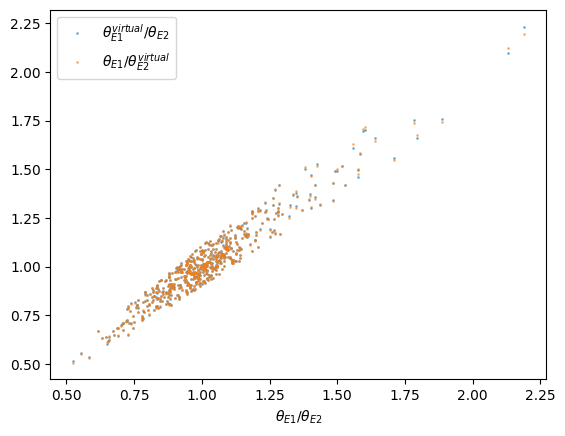

In [27]:
plt.plot(pairing_parameters_Table["theta_E1_by_theta_E2"], pairing_parameters_Table["theta_E1_virt_by_theta_E2"], "o", markersize=1, alpha=0.5, label=r"$\theta_{E1}^{virtual}/\theta_{E2}$")
plt.plot(pairing_parameters_Table["theta_E1_by_theta_E2"], pairing_parameters_Table["theta_E1_by_theta_E2_virt"], "o", markersize=1, alpha=0.5, label=r"$\theta_{E1}/\theta_{E2}^{virtual}$")
plt.xlabel(r"$\theta_{E1}/\theta_{E2}$")
plt.legend()

In [28]:
# compute the uncertainity on observed beta_E
sigma_beta_E_true = np.std(1 - (pairing_parameters_Table["theta_E1_by_theta_E2_virt"] + pairing_parameters_Table["theta_E1_virt_by_theta_E2"]) / (2 * pairing_parameters_Table["theta_E1_by_theta_E2"]))
print(f"Relative uncertainty on observed beta_E: {sigma_beta_E_true:.4f}")

Relative uncertainty on observed beta_E: 0.0538


In [29]:
# true cosmological parameters
Om_true = 0.3
w_true = -1.0
H0_true = 70.0
# cosmo_true = FlatwCDM(H0=H0_true, Om0=Om_true, w0=w_true)

# true deflector parameters
lambda_MST_true = 1.0
gamma_pl_true = 2.0

num_systems = len(pairing_parameters_Table)

# observed einstein radius ratios
beta_E_obs_arr = pairing_parameters_Table['theta_E1_by_theta_E2']
beta_E_obs_err_arr = beta_E_obs_arr * sigma_beta_E_true

# redshifts
z_lens_arr = pairing_parameters_Table['z_D1']
z_lens_arr += pairing_parameters_Table['z_D2']
z_lens_arr /= 2.0

z1_arr = pairing_parameters_Table['z_S1']
z2_arr = pairing_parameters_Table['z_S2']

In [30]:
## MCMC Sampling

# Set up MCMC Parameters
ndim = 4
nwalkers = 400
nsteps = 1000  # Reduced steps for quicker testing of optimization
nburn = 200

# Initialize Walkers [PARAMS: Omega_m, w, lambda_MST, gamma_pl]
initial_guess_means = np.array([0.3, -1, 1, 2.0])
initial_spreads = np.array([0.05, 0.2, 0.01, 0.01])
pos_initial = np.zeros((nwalkers, ndim))
for i in range(nwalkers):
    # Ensure initial positions are valid according to prior
    while True:
        p = initial_guess_means + initial_spreads * np.random.randn(ndim)
        if np.isfinite(log_prior(p)):
            # Optionally, also check if log_likelihood is finite for initial positions
            if np.all(np.isfinite(log_likelihood(p, z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr))):
                pos_initial[i,:] = p
                break


# Set up and Run the Sampler in Parallel
n_cores = cpu_count()
print(f"Running emcee with {n_cores} cores in parallel.")
print(f"Fitting for parameters: Omega_m, w, lambda_MST, gamma_pl")
print(f"Number of data systems: {num_systems}")
print(f"Initial guess means: {initial_guess_means}")

sampler_args = (z_lens_arr, z1_arr, z2_arr, beta_E_obs_arr, beta_E_obs_err_arr)

with Pool(processes=n_cores) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=sampler_args,
        pool=pool
    )

    print(f"Starting MCMC run: {nwalkers} walkers, {nsteps} steps...")
    sampler.run_mcmc(pos_initial, nsteps, progress=True)
    print("MCMC run finished.")

Running emcee with 11 cores in parallel.
Fitting for parameters: Omega_m, w, lambda_MST, gamma_pl
Number of data systems: 578
Initial guess means: [ 0.3 -1.   1.   2. ]
Starting MCMC run: 400 walkers, 1000 steps...


100%|██████████| 1000/1000 [08:08<00:00,  2.05it/s]

MCMC run finished.


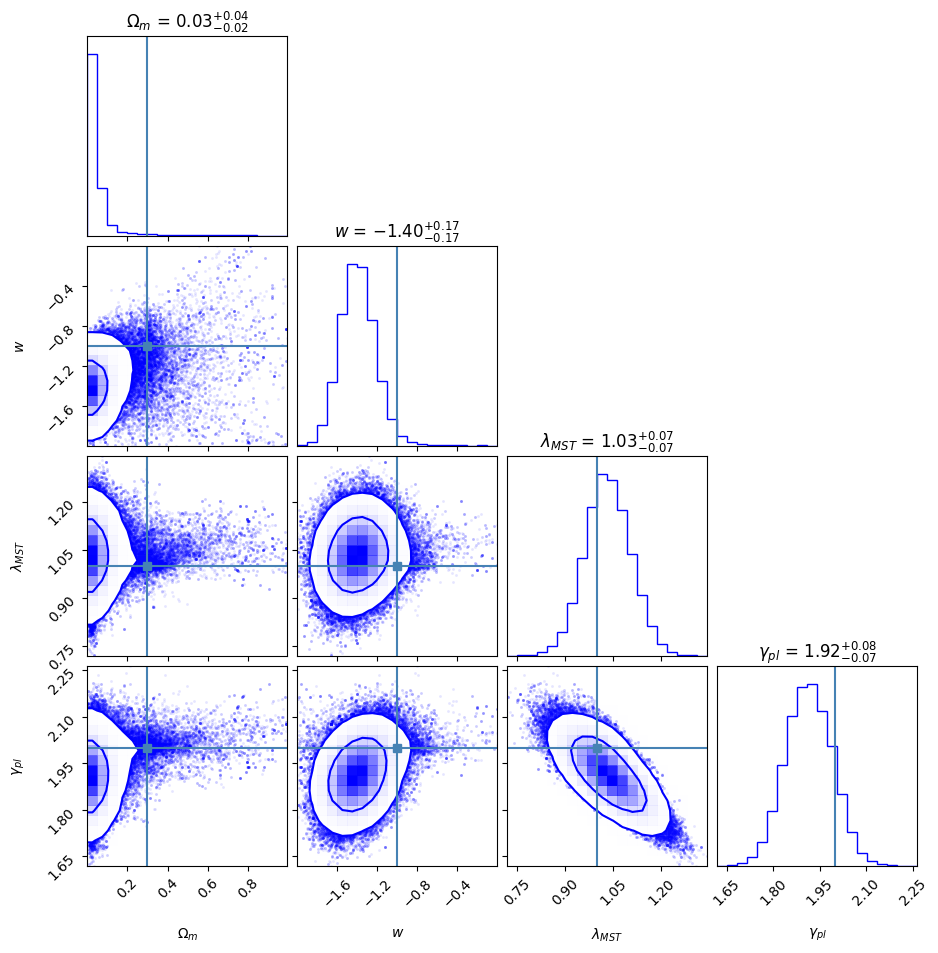

In [33]:
# plot the results
chain = sampler.get_chain(flat=True)

latex_labels = [r"$\Omega_m$", r"$w$", r"$\lambda_{MST}$", r"$\gamma_{pl}$"]

corner_fig = corner.corner(
    chain,
    labels=latex_labels,
    truths=[Om_true, w_true, lambda_MST_true, gamma_pl_true],
    # quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    levels=(0.68, 0.95),
    smooth=1,
    color="blue",
)

/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_11671/316324845.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_11671/316324845.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


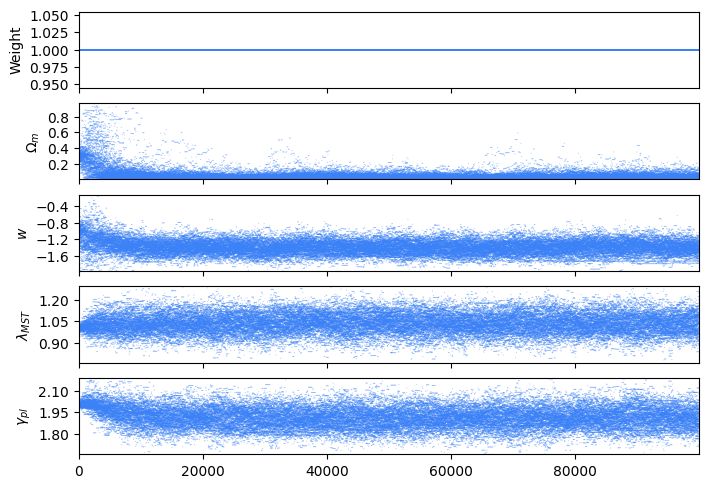

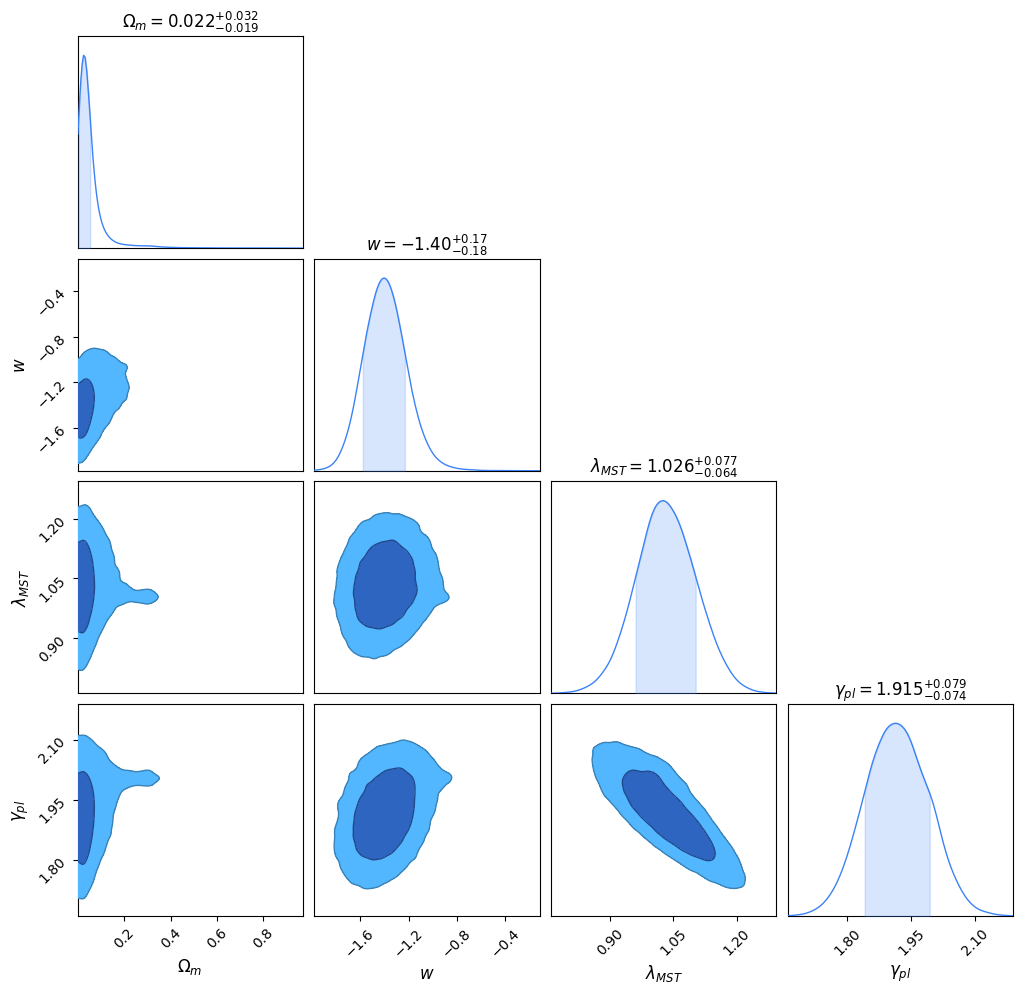

In [34]:
# make the plot using ChainConsumer
chain_dspl = Chain.from_emcee(
    sampler,
    latex_labels,
    latex_labels=latex_labels,
    name="MCMC Chain",
)

cc = ChainConsumer()
cc.add_chain(chain_dspl)
# cc.add_truth(
#     [Om_true, w_true, lambda_MST_true, gamma_pl_true]
# )
# cc.add_marker


# Plot the results using ChainConsumer
fig = cc.plotter.plot_walks()
fig.show()

fig = cc.plotter.plot()
fig.show()